This notebook builds a Recommendation System designed to suggest movies based on similarities in their associated tags. 

I chose Tags as parameters for comparison due to their ability to indicate movie content, which can potentially reveal similarities among different films.

# 1) Import and Understand the dataset
       

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt


tags_score_df = pd.read_csv(r"C:\Users\innyw\Downloads\archive (5)\genome_scores.csv")

tags_score_df.head()


,movie_id,tag_id,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [3]:
#rename fields 

tags_score_df.rename(columns = {"movie_id": "movie_id", "tag_id": "tag_id"}, inplace = True)

Tags have different relevance scores, meaning some are more important than others. To ensure meaningful comparisons, I focus only on the most relevant tags for each movie.

Determining how many tags to consider as relevant is crucial. To assess this, **let's first examine the number of tags each movie has.**


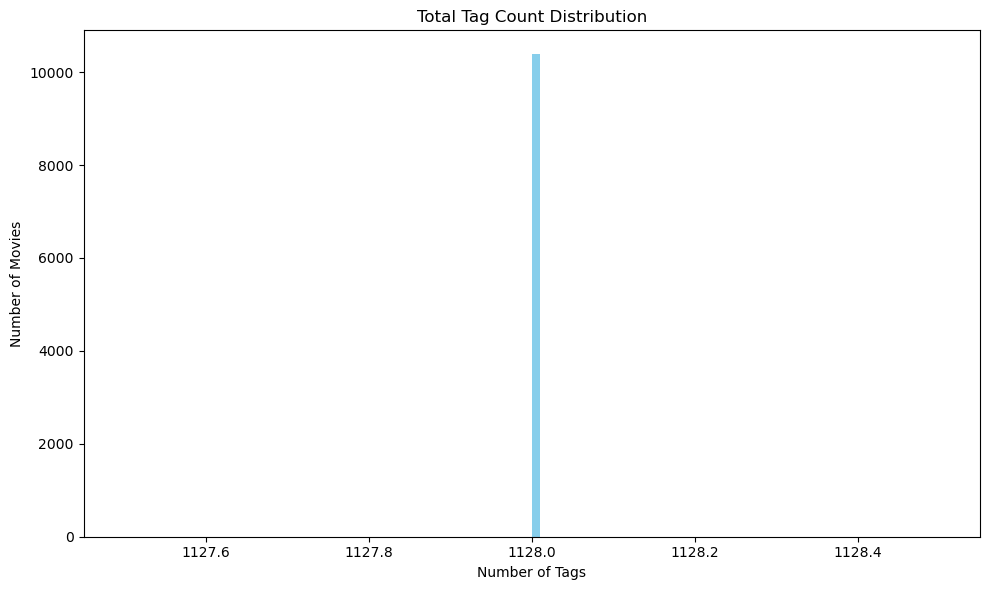

Total number of tags of all movies:  [1128]


In [4]:
#Group elements with same movie id and count all the associated tags, storing in a new column
tags_per_movie = tags_score_df.groupby(
    'movie_id')['tag_id'].size().reset_index(name='total_n_tags')

#Plot a histogram based on total number of tags. The frequency represent the number of movies.
plt.figure(figsize=(10, 6))
plt.hist(tags_per_movie['total_n_tags'], bins=100, color='skyblue')  
plt.title('Total Tag Count Distribution')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

#Double check if all the movies have  1128 tags.
print("Total number of tags of all movies: ", tags_per_movie['total_n_tags'].unique())


The movies share the same number of tags, allowing me to establish a standard tag range for all films. 

Beyond tag quantity, it's crucial to see whether most tags carry high relevance scores or the opposite. 

Let's visualize the overall pattern of relevance levels across different tags within this dataset.

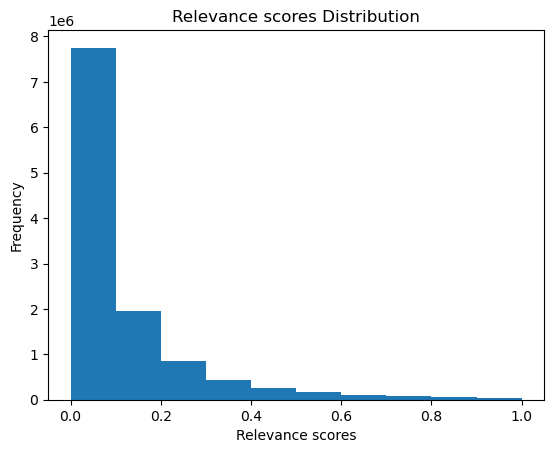

In [5]:
#Get the values of relevance column
x = tags_score_df['relevance']

#Plot the histogram of relevance scores
plt.hist(x)
plt.title('Relevance scores Distribution')
plt.xlabel('Relevance scores')
plt.ylabel('Frequency')
plt.show()


### Determining the Threshold for Relevant Tag Scores

Most tags have low relevance scores, typically between 0 and 0.2, with a maximum of 1.0. Since many tags are only weakly related to their movies, including too many could dilute the recommendation quality. However, if we use too few tags, we might miss important ones. The key challenge is **finding a balanced cutoff**—a point where we include enough relevant tags without adding those that are too weak.

To address this, we analyze the pattern of tag relevance scores across different tags' ranks of all movies. Instead of setting an arbitrary threshold, we calculate the *median* relevance score for each rank and plot the percentage change across ranks. This helps identify which relevance score stops being meaningful and define a reasonable range of tags for finding similar movies.

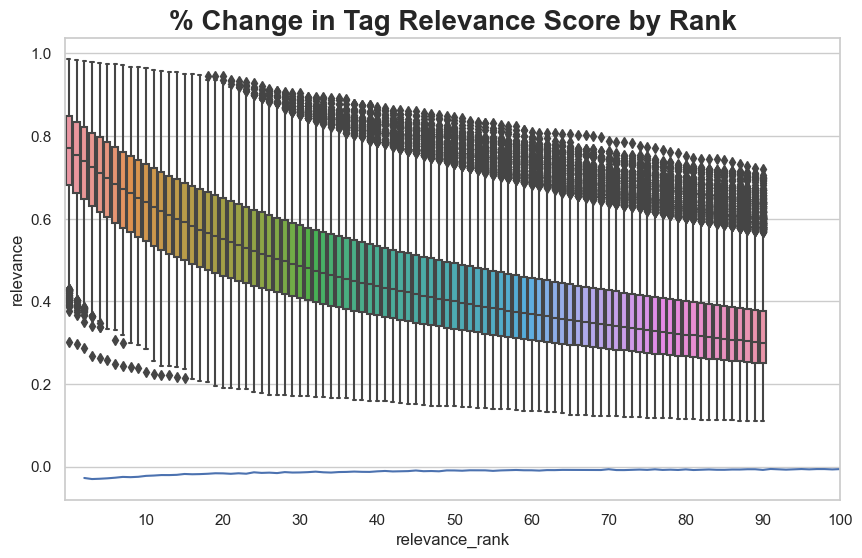

In [6]:

import seaborn as sns


#Creeate a relevance_rak column that rank tags for each movie 
tags_score_df['relevance_rank'] = tags_score_df.groupby("movie_id")["relevance"].rank(method = "first", ascending = False).astype('int64')

#Group by the same rank and calculate their median. Get the first 100 ranks
tags_rank = tags_score_df.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)


#Compute the variation among different ranks' medians in percentage
tags_rank['relevance_median_pct_chg'] = tags_rank['relevance_median'].pct_change()


sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 6))

#Output a line that represents the percentage change
ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = tags_rank)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

#Output boxplots to display the median, the range, and outliers of the ranks stored in tags_rank
ax = sns.boxplot(
    x="relevance_rank",
    y="relevance",
     data=tags_score_df[
        (tags_score_df['relevance_rank'] >= 10) & (tags_score_df['relevance_rank'] <= 100)
    ],showfliers=True)

plt.xticks(range(10,110,10))
ax.set_xticklabels(range(10, 110, 10))
plt.show()




Starting at relevance_rank 50, the blue line becomes nearly constant. **To ensure this isn't due to missing data beyond rank 50**, let's perform a quick verification.


In [7]:
#Get the rank between 60th and 100th  
range_check = tags_score_df[(tags_score_df['relevance_rank'] >= 60) & (tags_score_df['relevance_rank'] <= 100)
]

# Check if there are any rows in the specified range
if range_check.empty:
    print("No values found in the 'relevance_rank' column between 60+ and 100.")
else:
    print("Values found in the 'relevance_rank' column between 60+ and 100.")
    print(f"There are {len(range_check)} rows")

Values found in the 'relevance_rank' column between 60+ and 100.
There are 425621 rows


Data exists within relevance ranks from 60th to 100th, confirming that the consistency in percentage change is due to minimal or no variation, rather than missing data.

**Since ranks 0 to 50 show noticeable variation in the median, let's narrow our focus to this range.**


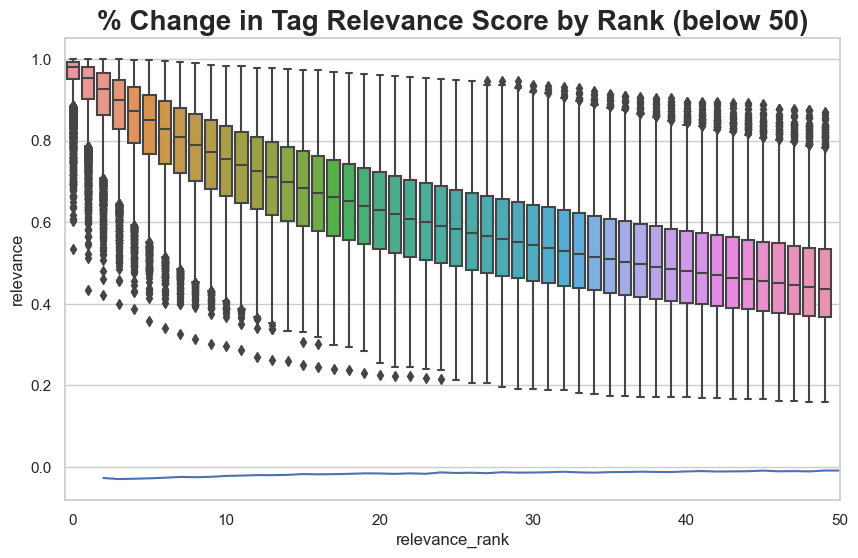

In [8]:
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = tags_rank)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank (below 50)", fontsize = 20, weight = 'bold')

ax = sns.boxplot(
    x="relevance_rank",
    y="relevance",
     data=tags_score_df[
        (tags_score_df['relevance_rank'] <=50)],showfliers=True)

plt.xticks(range(0,60,10))
ax.set_xticklabels(range(0, 60, 10))
plt.show()


Indeed, before the 50th relevance rank, the graph displays a noticeable decrease in the median relevance score as it approaches 50. Hence, it's more meaningful to consider a range of tags from the 1st to the 50th.

# 2) Filtering the datasets and merging with others to focus on key variables

2.1) Let's filter the dataframe into top 50 relevant scores

In [12]:
# Sort the tags by relevance score within each movie
tags_score_df = tags_score_df.sort_values(['movie_id', 'relevance_rank'])


# Group by movie_id and select the top 50 tags or fewer
relevant_tags_df = tags_score_df.groupby('movie_id').head(50)

In [13]:
relevant_tags_df

,movie_id,tag_id,relevance,relevance_rank
1035,1,1036,0.99925,1
243,1,244,0.99850,2
785,1,786,0.99600,3
588,1,589,0.99075,4
63,1,64,0.98575,5
...,...,...,...,...
11709013,131170,374,0.64400,46
11709712,131170,1073,0.64400,47
11709762,131170,1123,0.64375,48
11709366,131170,727,0.64050,49


In [14]:
#Do a quick check if all movies have 50 distinct tags 

# Count the number of distinct tags for each movie
tag_counts = relevant_tags_df.groupby(
    "movie_id")["tag_id"].nunique().reset_index(name="distinct_tag_count")

# Check if all movies have exactly 50 distinct tags
all_movies_have_50_tags = tag_counts["distinct_tag_count"].eq(50).all()

print("All movies have exactly 50 distinct tags", all_movies_have_50_tags)


All movies have exactly 50 distinct tags True


2.2) The first dataframe only contains tag_id and tag relevance data. To incorporate tag names, movie IDs, and movie titles, we will merge the relevant_tags_df with other datasets.

In [15]:
#Import datasets
genome_tag_df = pd.read_csv(
    r"C:\Users\innyw\Downloads\archive (5)\genome_tags.csv")
tag_df = pd.read_csv(r"C:\Users\innyw\Downloads\archive (5)\tag.csv")
movie_df = pd.read_csv(r"C:\Users\innyw\Downloads\archive (5)\movie.csv")

In [16]:
movie_df.rename(columns = {"movieId": "movie_id"}, inplace = True)
tag_df.rename(columns={"movieId": "movie_id", "userId": "user_id"}, inplace=True)
genome_tag_df.rename(
    columns={"tagId": "tag_id"}, inplace=True)

In [17]:


# Merge genome_tags_df and relevant_tags_df on 'tag_id'
merged_genome_tags = pd.merge(genome_tag_df, relevant_tags_df, on='tag_id', how='inner')

# Merge tag_df with the merged DataFrame on 'movie_id' and 'tag'
merged_movie = pd.merge(merged_genome_tags, tag_df, on=['tag','movie_id'], how='inner')
movie_tags_df = pd.merge(merged_movie,movie_df, on = ['movie_id'],how = 'inner')





In [18]:
#Check if there are duplicates
duplicated_movies_tags = movie_tags_df[movie_tags_df.duplicated(subset=['movie_id', 'tag'], keep = False)]
duplicated_movies_tags

,tag_id,tag,movie_id,relevance,relevance_rank,user_id,timestamp,title,genres
0,1,007,10,0.99975,1,8527,2008-04-09 18:51:53,GoldenEye (1995),Action|Adventure|Thriller
1,1,007,10,0.99975,1,11074,2006-02-24 13:46:22,GoldenEye (1995),Action|Adventure|Thriller
2,1,007,10,0.99975,1,14260,2006-02-06 04:17:28,GoldenEye (1995),Action|Adventure|Thriller
3,1,007,10,0.99975,1,77058,2009-05-04 00:12:00,GoldenEye (1995),Action|Adventure|Thriller
4,1,007,10,0.99975,1,81725,2009-06-05 13:05:59,GoldenEye (1995),Action|Adventure|Thriller
...,...,...,...,...,...,...,...,...,...
166184,1128,zombies,63826,0.66925,18,25737,2011-11-29 02:13:06,Splinter (2008),Action|Horror|Thriller
166185,1128,zombies,63826,0.66925,18,28906,2010-04-02 23:08:04,Splinter (2008),Action|Horror|Thriller
166186,1128,zombies,63826,0.66925,18,99342,2010-10-20 21:14:48,Splinter (2008),Action|Horror|Thriller
166187,1128,zombies,75425,0.98250,2,10514,2013-01-21 17:20:08,Survival of the Dead (2009),Horror


The duplicates are likely due to different users assigning the same tags to the same movies. Let's verify this assumption.
To verify this, we will filter all duplicated rows and check if all of them have more than one unique user_id. If yes, this confirms that all duplicated movies and tags are due to different users tagging the same thing. 

In [19]:
# Count the number of unique users for each (movie_id, tag) pair

duplicated_movies_tags_n_users = duplicated_movies_tags.groupby(["movie_id", "tag"])[
    "user_id"].nunique().reset_index()

# Filter cases where there is NO more than users assigned the same tag to the same movie
multiple_users_per_tag = duplicated_movies_tags_n_users[duplicated_movies_tags_n_users["user_id"] <= 1]

multiple_users_per_tag

,movie_id,tag,user_id


Since there are no duplicated movie-tag pairs with only one unique user, this confirms that duplicates exist because multiple users assigned the same tag to the same movie.


2.3 ) Check Null values

In [20]:
#Check null values 
print("Null values: \n")
movie_tags_df.isna().sum()

Null values: 



tag_id            0
tag               0
movie_id          0
relevance         0
relevance_rank    0
user_id           0
timestamp         0
title             0
genres            0
dtype: int64

# 3) Identify similarities among movies

3.1) Finding Similar Movies Based on Shared Tags  

Now that we have a dataset with each movie’s **top 50 tags**, we can use them to compare similarities among movies. To do this, we will create a function that measures similarity based on the **number of identical tag IDs** shared between two movies.  

In [36]:
def find_movies_w_same_tags(this_movie_title):
    # Ensure each (movie, tag) pair is unique
    unique_movie_tags_df = movie_tags_df[['title', 'tag_id']].drop_duplicates()

    # Extract tags of the selected movie
    selected_movie_tags = unique_movie_tags_df[unique_movie_tags_df['title']
                                               == this_movie_title]

    # Merge to find other movies that share tags with the selected movie
    merged_df = unique_movie_tags_df.merge(
        selected_movie_tags,
        on='tag_id',
        suffixes=('_other', '_this')
    )

    # Exclude the selected movie itself
    merged_df = merged_df[merged_df['title_other'] != this_movie_title]

    # Count matching tags per movie
    tag_counts = merged_df.groupby('title_other')[
        'tag_id'].count().reset_index(name='match_count')

    # Get the top 3 most similar movies
    top_movies = tag_counts.nlargest(3, 'match_count')

    # Calculate similarity percentage (ensuring it doesn't exceed 100%)
    top_movies['similarity_percent'] = (
        top_movies['match_count'] / 50 * 100).round()

    # Convert results to a dictionary
    recommend_movies = dict(
        zip(top_movies['title_other'], top_movies['similarity_percent']))

    return recommend_movies,top_movies

In [ ]:
#Test
recom_movies, df = find_movies_w_same_tags('GoldenEye (1995)')
recom_movies, df

({'Casino Royale (2006)': 18.0,
  'Goldfinger (1964)': 18.0,
  'From Russia with Love (1963)': 16.0},
                       title_other  match_count  similarity_percent
 119          Casino Royale (2006)            9                18.0
 266             Goldfinger (1964)            9                18.0
 246  From Russia with Love (1963)            8                16.0)